Using device: cuda
Train shape: (409, 2)
Test shape: (197, 1)
    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5
Example audio path: C:\Users\Asus\StudioProjects\NLP Agent\shl-intern-hiring-assessment-2025\dataset\audios\train\audio_173


Estimating durations:   0%|          | 0/50 [00:00<?, ?it/s]

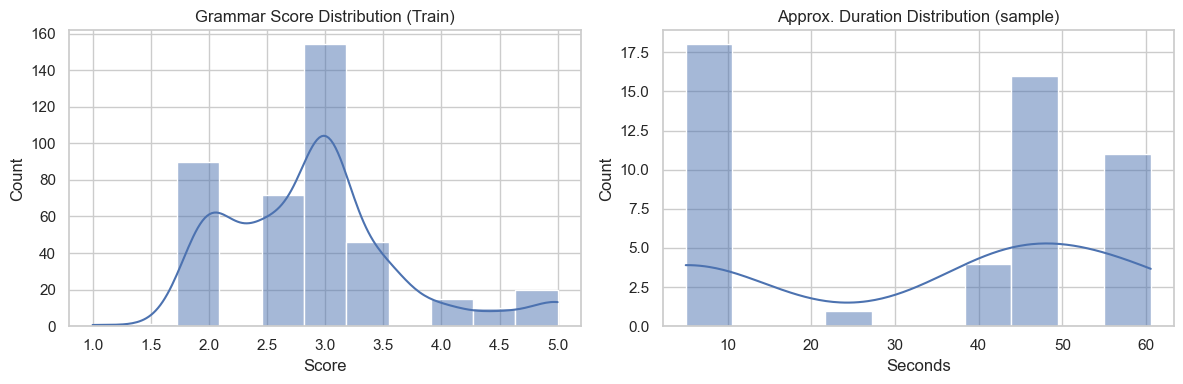

Example feature shape: (128,)
Input feature dimension: 128
MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

===== Fold 1/5 =====
Epoch 01 | train RMSE: 2.2054 | val RMSE: 2.4093, val Pearson: 0.1723
Epoch 02 | train RMSE: 1.7810 | val RMSE: 1.9434, val Pearson: 0.1907
Epoch 03 | train RMSE: 1.5670 | val RMSE: 1.7286, val Pearson: 0.3109
Epoch 04 | train RMSE: 1.0943 | val RMSE: 1.2382, val Pearson: 0.3264
Epoch 05 | train RMSE: 0.8903 | val RMSE: 1.0125, val Pearson: 0.2482
Epoch 06 | train RMSE: 0.7775 | val RMSE: 0.8542, val Pea

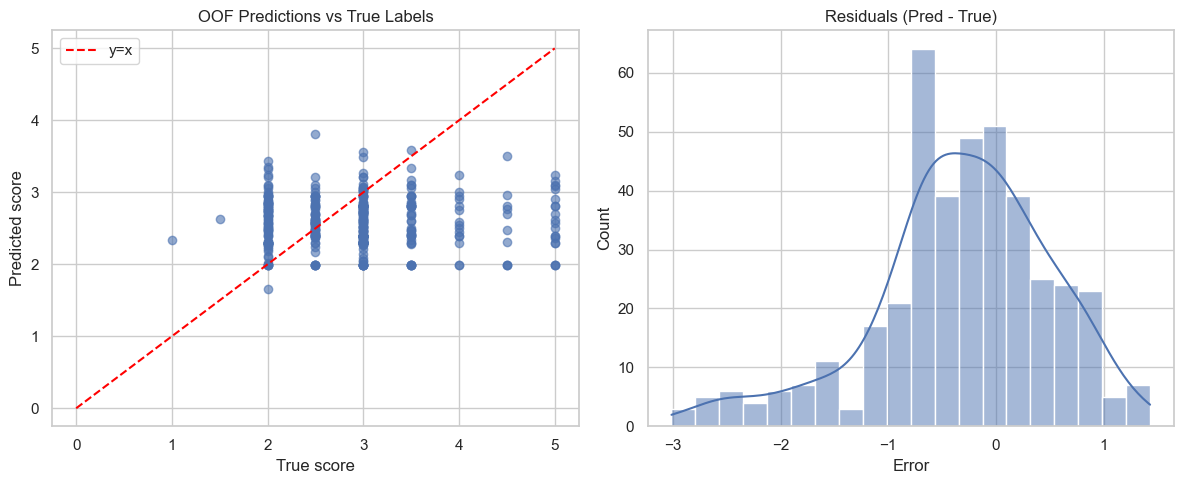

Epoch 01 | Full-train RMSE: 2.2383
Epoch 02 | Full-train RMSE: 1.6702
Epoch 03 | Full-train RMSE: 1.1803
Epoch 04 | Full-train RMSE: 1.0146
Epoch 05 | Full-train RMSE: 0.8604
Epoch 06 | Full-train RMSE: 0.7642
Epoch 07 | Full-train RMSE: 0.7740
Epoch 08 | Full-train RMSE: 0.8108
Epoch 09 | Full-train RMSE: 0.7636
Epoch 10 | Full-train RMSE: 0.7973
Epoch 11 | Full-train RMSE: 0.7830
Epoch 12 | Full-train RMSE: 0.7907
Epoch 13 | Full-train RMSE: 0.7842
Epoch 14 | Full-train RMSE: 0.7459
Epoch 15 | Full-train RMSE: 0.9127
Epoch 16 | Full-train RMSE: 0.7633
Epoch 17 | Full-train RMSE: 0.8344
Epoch 18 | Full-train RMSE: 0.7947
Epoch 19 | Full-train RMSE: 0.8863
Epoch 20 | Full-train RMSE: 0.7788
Epoch 21 | Full-train RMSE: 0.7395
Epoch 22 | Full-train RMSE: 0.7530
Epoch 23 | Full-train RMSE: 0.8419
Epoch 24 | Full-train RMSE: 0.7560
Epoch 25 | Full-train RMSE: 0.7276
Epoch 26 | Full-train RMSE: 0.8407
Epoch 27 | Full-train RMSE: 0.8174
Epoch 28 | Full-train RMSE: 0.7859
Epoch 29 | Full-trai

Predicting on test:   0%|          | 0/13 [00:00<?, ?it/s]

Submission file saved to: C:\Users\Asus\StudioProjects\NLP Agent\shl-intern-hiring-assessment-2025\dataset\csvs\submission.csv
    filename     label
0  audio_141  2.968601
1  audio_114  2.421003
2   audio_17  2.791146
3   audio_76  3.202055
4  audio_156  2.453074


In [24]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm.auto import tqdm
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

sns.set(style="whitegrid", context="notebook")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

DATA_DIR = r"C:\Users\Asus\StudioProjects\NLP Agent\shl-intern-hiring-assessment-2025\dataset\csvs"
TRAIN_AUDIO_DIR = r"C:\Users\Asus\StudioProjects\NLP Agent\shl-intern-hiring-assessment-2025\dataset\audios\train"
TEST_AUDIO_DIR  = r"C:\Users\Asus\StudioProjects\NLP Agent\shl-intern-hiring-assessment-2025\dataset\audios\test"

train_csv_path = os.path.join(DATA_DIR, "train.csv")
test_csv_path = os.path.join(DATA_DIR, "test.csv")

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

audio_example = train_df["filename"].iloc[0]
example_path = os.path.join(TRAIN_AUDIO_DIR, audio_example)
print("Example audio path:", example_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df["label"], bins=11, kde=True, ax=axes[0])
axes[0].set_title("Grammar Score Distribution (Train)")
axes[0].set_xlabel("Score")

SR = 16000
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256

def load_audio(path, sr=SR):
    try:
        from scipy.io import wavfile
        orig_sr, y = wavfile.read(path)
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        if y.dtype == np.int16:
            y = y.astype(np.float32) / 32768.0
        elif y.dtype == np.int32:
            y = y.astype(np.float32) / 2147483648.0
        elif y.dtype == np.uint8:
            y = y.astype(np.float32) / 128.0 - 1.0
        elif y.dtype == np.float32 or y.dtype == np.float64:
            y = y.astype(np.float32)
            if np.abs(y).max() > 1.0:
                y = y / np.abs(y).max()
        else:
            y = y.astype(np.float32)
            if np.abs(y).max() > 1.0:
                y = y / (np.abs(y).max() + 1e-9)
        if orig_sr != sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
        return y, sr
    except Exception as e1:
        try:
            import wave
            with wave.open(path, 'rb') as wav_file:
                orig_sr = wav_file.getframerate()
                n_frames = wav_file.getnframes()
                n_channels = wav_file.getnchannels()
                sample_width = wav_file.getsampwidth()
                frames = wav_file.readframes(n_frames)
            if sample_width == 1:
                y = np.frombuffer(frames, dtype=np.uint8).astype(np.float32)
                y = y / 128.0 - 1.0
            elif sample_width == 2:
                y = np.frombuffer(frames, dtype=np.int16).astype(np.float32) / 32768.0
            elif sample_width == 3:
                y = np.frombuffer(frames, dtype=np.uint8)
                y = y.reshape(-1, 3).astype(np.int32)
                y = ((y[:, 0] | (y[:, 1] << 8) | (y[:, 2] << 16)) - 8388608).astype(np.float32) / 8388608.0
            elif sample_width == 4:
                y = np.frombuffer(frames, dtype=np.int32).astype(np.float32) / 2147483648.0
            else:
                y = np.frombuffer(frames, dtype=np.int16).astype(np.float32) / 32768.0
            if n_channels > 1:
                y = y.reshape(-1, n_channels).mean(axis=1)
            if orig_sr != sr:
                y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
            return y, sr
        except Exception as e2:
            try:
                y, orig_sr = librosa.load(path, sr=None, mono=True)
                if orig_sr != sr:
                    y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
                return y, sr
            except Exception as e3:
                try:
                    wav, orig_sr = torchaudio.load(path)
                    if wav.shape[0] > 1:
                        wav = wav.mean(dim=0, keepdim=True)
                    if orig_sr != sr:
                        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=sr)
                        wav = resampler(wav)
                    y = wav.squeeze(0).numpy().astype(np.float32)
                    return y, sr
                except:
                    pass
                y = np.zeros(sr * 5, dtype=np.float32)
                return y, sr

sample_files = train_df["filename"].sample(min(50, len(train_df)), random_state=SEED)
durations = []
for fname in tqdm(sample_files, desc="Estimating durations"):
    fpath = os.path.join(TRAIN_AUDIO_DIR, fname + ".wav")
    try:
        y, sr = load_audio(fpath)
        durations.append(len(y) / sr)
    except Exception:
        continue

if durations:
    sns.histplot(durations, bins=10, kde=True, ax=axes[1])
    axes[1].set_title("Approx. Duration Distribution (sample)")
    axes[1].set_xlabel("Seconds")
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()

def extract_logmel(y, sr, n_mels=N_MELS):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=n_mels,
        power=2.0,
    )
    logmel = librosa.power_to_db(mel + 1e-9)
    return logmel

def aggregate_features(logmel: np.ndarray):
    mean_feat = logmel.mean(axis=1)
    std_feat = logmel.std(axis=1)
    return np.concatenate([mean_feat, std_feat], axis=0).astype(np.float32)

example_wav_path = example_path + ".wav"
if os.path.isfile(example_wav_path):
    y, sr = load_audio(example_wav_path)
    logmel = extract_logmel(y, sr)
    feat = aggregate_features(logmel)
    print("Example feature shape:", feat.shape)
    in_dim = feat.shape[0]
else:
    in_dim = N_MELS * 2
    print("Example audio file not found - using default input dimension:", in_dim)

class AudioFeatureDataset(Dataset):
    def __init__(self, df, audio_dir, is_train=True):
        self.df = df.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def _resolve_path(self, fname):
        base_path = os.path.join(self.audio_dir, fname)
        if os.path.isfile(base_path):
            return base_path
        wav_path = base_path + ".wav"
        if os.path.isfile(wav_path):
            return wav_path
        return base_path

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["filename"]
        label = row["label"] if self.is_train else None
        path = self._resolve_path(fname)
        y, sr = load_audio(path)
        logmel = extract_logmel(y, sr)
        feat = aggregate_features(logmel)
        x = torch.from_numpy(feat)
        if self.is_train:
            y_label = torch.tensor(label, dtype=torch.float32)
            return x, y_label
        else:
            return x

class MLPRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dims=(128, 64), dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

print("Input feature dimension:", in_dim)
model = MLPRegressor(in_dim=in_dim).to(DEVICE)
print(model)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            preds = model(x)
            preds_list.append(preds.cpu().numpy())
            targets_list.append(y.cpu().numpy())
    y_true = np.concatenate(targets_list)
    y_pred = np.concatenate(preds_list)
    return y_true, y_pred

N_SPLITS = 5
EPOCHS = 30
BATCH_SIZE = 16
LR = 1e-3

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_targets = train_df["label"].values.astype(np.float32)
oof_preds = np.zeros_like(train_targets, dtype=np.float32)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
    print(f"\n===== Fold {fold}/{N_SPLITS} =====")
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    train_dataset = AudioFeatureDataset(train_fold_df, audio_dir=TRAIN_AUDIO_DIR, is_train=True)
    val_dataset = AudioFeatureDataset(val_fold_df, audio_dir=TRAIN_AUDIO_DIR, is_train=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    model = MLPRegressor(in_dim=in_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    best_val_rmse = float("inf")
    best_state = None
    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        y_true_val, y_pred_val = eval_model(model, val_loader)
        val_rmse = rmse(y_true_val, y_pred_val)
        val_pearson = pearsonr(y_true_val, y_pred_val)[0]
        y_true_tr, y_pred_tr = eval_model(model, train_loader)
        train_rmse_fold = rmse(y_true_tr, y_pred_tr)
        print(
            f"Epoch {epoch:02d} | train RMSE: {train_rmse_fold:.4f} | "
            f"val RMSE: {val_rmse:.4f}, val Pearson: {val_pearson:.4f}"
        )
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    y_true_val, y_pred_val = eval_model(model, val_loader)
    oof_preds[val_idx] = y_pred_val
    fold_rmse = rmse(y_true_val, y_pred_val)
    fold_pearson = pearsonr(y_true_val, y_pred_val)[0]
    fold_metrics.append((fold_rmse, fold_pearson))
    print(f"Fold {fold} best val RMSE: {fold_rmse:.4f}, Pearson: {fold_pearson:.4f}")

global_rmse = rmse(train_targets, oof_preds)
global_pearson = pearsonr(train_targets, oof_preds)[0]
print("\n===== Cross-Validation Summary =====")
for i, (fr, fp) in enumerate(fold_metrics, 1):
    print(f"Fold {i}: RMSE={fr:.4f}, Pearson={fp:.4f}")
print(f"Global OOF RMSE: {global_rmse:.4f}")
print(f"Global OOF Pearson: {global_pearson:.4f}")

clipped_oof = np.clip(oof_preds, 0.0, 5.0)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(train_targets, clipped_oof, alpha=0.6)
axes[0].plot([0, 5], [0, 5], color="red", linestyle="--", label="y=x")
axes[0].set_xlabel("True score")
axes[0].set_ylabel("Predicted score")
axes[0].set_title("OOF Predictions vs True Labels")
axes[0].legend()
residuals = clipped_oof - train_targets
sns.histplot(residuals, bins=20, kde=True, ax=axes[1])
axes[1].set_title("Residuals (Pred - True)")
axes[1].set_xlabel("Error")
plt.tight_layout()
plt.show()

full_train_dataset = AudioFeatureDataset(train_df, audio_dir=TRAIN_AUDIO_DIR, is_train=True)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
final_model = MLPRegressor(in_dim=in_dim).to(DEVICE)
optimizer = torch.optim.Adam(final_model.parameters(), lr=LR)
criterion = nn.MSELoss()
BEST_EPOCHS = 40

for epoch in range(1, BEST_EPOCHS + 1):
    train_loss = train_one_epoch(final_model, full_train_loader, optimizer, criterion)
    y_true_tr, y_pred_tr = eval_model(final_model, full_train_loader)
    train_rmse_full = rmse(y_true_tr, y_pred_tr)
    print(f"Epoch {epoch:02d} | Full-train RMSE: {train_rmse_full:.4f}")

print(f"\nFinal training RMSE on full training data: {train_rmse_full:.4f}")

test_dataset = AudioFeatureDataset(test_df, audio_dir=TEST_AUDIO_DIR, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
final_model.eval()
all_test_preds = []
with torch.no_grad():
    for x in tqdm(test_loader, desc="Predicting on test"):
        x = x.to(DEVICE)
        preds = final_model(x)
        all_test_preds.append(preds.cpu().numpy())

all_test_preds = np.concatenate(all_test_preds)
all_test_preds = np.clip(all_test_preds, 0.0, 5.0)

submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": all_test_preds,
})

submission_path = os.path.join(DATA_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)
print("Submission file saved to:", submission_path)
print(submission.head())

